# Section 1: Downloading  and pre-processing Landsat satellite imagery 

## Overview

Objectives:
   * Get familiar with Landsat satellite imagery and understand the basic concepts of how to access the data. 
   * Automate the download of Landsat images through Google for a given Region of Interest (ROI).
   * Pre-process the imagery for further analysis.

NASA's Landsat satellite programme is the longest standing programme for Earth observation (EO) imagery. It provides an open source, 46 year record of moderate resolution imagery and in addition captures Near- and Shortwave-Infrared, Thermal, and for the more recent missions, cirrus and panchromatic images. 

| Mission | Operational time | Revisit time | Resolution |
|---|---|----|---|
| Landsat 1 | 1972-1978 | 18 d | 80 m |
| Landsat 2 | 1975-1982 | 18 d | 80 m |
| Landsat 3 | 1978-1983 | 18 d | 80 m |
| Landsat 4 | 1983-1993 | 16 d | 30 m |
| Landsat 5 | 1984-2013 | 16 d | 30 m |
| Landsat 7 | 1999-present | 16 d |15 m |
| Landsat 8 | 2013-present | 16 d | 15 m|

Other sources for free EO satellite imagery are:

| Provider | Programme | Operational time | Revisit time | Resolution |
|-|---|----|---|
|European Space Agency | Sentinel | 2015-present| 5 d | 10m |
|Planet Labs | Rapideye <br>Planetscope<br>Skysat | 2009-present | 4/5 d to daily | up to 0.8 m |
|NASA | Orbview 3 | 2003-2007 | < 3 d |1-4 m |
|NASA | EO-1 | 2003 -2017 | -- | 10-30 m|


The Python libraries used in this tutorial are the following

* [Matplotolib](https://matplotlib.org/contents.html):A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. 
* [Numpy](https://docs.scipy.org/doc/): Adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/):  Provides high-performance, easy-to-use data structures and data analysis tools 
* [GeoPandas](http://geopandas.org/): Python library that simplifies working with geospatil data
* [Folium](http://folium.readthedocs.io/en/latest/): Python library that enables plotting interactive maps using leaflet
* [Glob](https://docs.python.org/2/library/glob.html): Unix style pathname pattern expansion
* [Landsat578](https://github.com/dgketchum/Landsat578): Simple Landsat imagery download tool
* [Scikit-image](http://scikit-image.org/docs/dev/): Collection of algorithms for image processing
* [Wget](https://pypi.org/project/wget/): Pure python download utility


## Install all packages using Conda environment

In the Anaconda command line navigate to the folder where the _workshop.yml_ file is located and run the following code:

* conda env create -f workshop.yml

In [2]:
# Import the packages you need to download satellite data

# Plots graphs and figures within the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import os, shutil
import glob
from landsat import google_download
from google_download import GoogleDownload
from skimage import io, transform, exposure
import wget

* Read in the bounding box shapefile

In order to intersect our bounding box with the flight path of the satellite the coordinate system of the shapefile has to be WGS84 lat-long, which is equivalent to EPSG:4326.

In [2]:
# Specify the path to your shapefile
shp='../data/Liverpool/Liverpool.shp'

# Read the shapefile into a geopandas GeoDataFrame
box = gpd.read_file(shp)

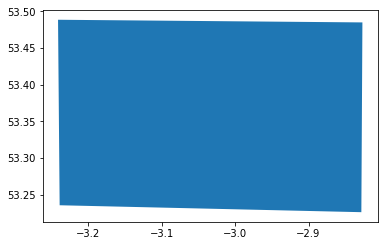

In [3]:
# Change Coordinate Reference System to WGS84 (EPSG 4326) so that it can be 
# intersected with the WRS file and plot it
bbox=box.to_crs({'init':'epsg:4326'})
bbox.plot()

The `data/wrs2_descending` folder includes a shapefile which contains the flight path of the Landsat satellites and shows the paht/row tuples.

* Intersect the two shapefiles

To determine which images are relevant for our ROI, we need to intersect the flight path of the Landsat satellite with our ROI. This will give us path/row tuples that intersect with our ROI

In [5]:
# Read the WRS file into a GeoPanda DataFrame
wrs=gpd.GeoDataFrame.from_file('../data/wrs2/wrs2_descending.shp')

In [6]:
# Check which polygons of the WRS file intersect with our shapefile geometry
wrs_intersection=wrs[wrs.intersects(bbox.geometry[0])]

In [7]:
# Specify that paths,rows variables are the ones that intersect
paths,rows=wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

* Visualise the interesecting shapefiles

This allows us to sort out images (path/row tuples) that only partially intersect with our ROI. 

In [8]:
# Visualise the output of the intersection with the shapefile using Folium

# Get the center of the map
xy = np.asarray(bbox.centroid[0].xy).squeeze()
center = list(xy[::-1])

# Select a zoom
zoom =8

# Create the most basic OSM folium map
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)

# Add the bounding box (bbox) GeoDataFrame in red using a lambda function
m.add_child(folium.GeoJson(bbox.__geo_interface__, name='Area of Interest', 
                            style_function=lambda x: {'color': 'red', 'alpha': 0}))


# Iterate through each polygon of paths and rows intersecting the area
for i, row in wrs_intersection.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)
m

In [9]:
# Display number of images and Path/Row of the image
for i, (path,row) in enumerate(zip(paths,rows)):
    print('Image', i+1, ' -path:', path, 'row:', row)

Image 1  -path: 203 row: 23
Image 2  -path: 204 row: 23


# Download Landsat images from Google

* As we now have the relevant path/row tuples for our ROI we can proceed to download the images. We can specifiy a time frame as well as the satellite we would like to obtain data from. Furthermore, we can specifiy the percentage of cloud cover in the image.

In [ ]:
# Download Tile list from Google - only needs to be done when first running 
# the code 

#Path to index file
Index_PATH='../data/index.csv.gz'
if os.path.exists(Index_PATH):
    print('File already exists')

else:
    ! landsat --update-scenes yes
    ! mv index.csv.gz ../data/index.csv.gz

In [10]:
# Define Google Download function

def landsat_download(start_date, end_date, sat,path,row,cloud,output):
    g=GoogleDownload(start=start_date, end=end_date, satellite=sat, path=path, row=row, max_cloud_percent=cloud, output_path=output)
    g.download()

In [11]:
# Specify start and end date YYYY-MM-DD, which satellites to use [1-8] and the
# output path where the files should be saved
start_date='2017-01-01'
end_date = '2018-06-01'
cloud = 10
satellites=[8]
home = '../data/'
output = os.path.join(home, 'Landsat_images')

In [12]:
# Loop through the specified satellites for each path and row tuple
for sat in satellites:
    for i, (path,row) in enumerate(zip(paths,rows)):
        print('Image', i+1, ' -path:', path, 'row:', row)
        landsat_download(start_date, end_date,sat,path,row,cloud,output)

Image 1  -path: 203 row: 23


MemoryError: 

# Crop to ROI and create RGB image

* As we are only interested in our ROI we can crop the Landsat image to our ROI. 

In [3]:
# Define cropping function using command line gdalwarp
def cropp(inraster,outraster,shape):
        !gdalwarp -cutline {shape} -srcnodata 0  -crop_to_cutline {inraster} {outraster}

In [15]:
# Loop through every folder and a create an image cropped to the extent of the shapefile
# save it with the original name and the extension _Cropped
for filename in glob.iglob('../data/**/*.TIF', recursive=True):
    inraster = filename
    outraster = filename[:-4] + '_Cropped.TIF'    
    cropp(inraster, outraster, shp)
    print(outraster)

0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/user/Desktop/Workshop\Landsat_images\LC82040232017198LGN00\LC08_L1TP_204023_20170717_20170727_01_T1_B1_Cropped.TIF
0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/user/Desktop/Workshop\Landsat_images\LC82040232017198LGN00\LC08_L1TP_204023_20170717_20170727_01_T1_B10_Cropped.TIF
0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/user/Desktop/Workshop\Landsat_images\LC82040232017198LGN00\LC08_L1TP_204023_20170717_20170727_01_T1_B11_Cropped.TIF
0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/user/Desktop/Workshop\Landsat_images\LC82040232017198LGN00\LC08_L1TP_204023_20170717_20170727_01_T1_B2_Cropped.TIF
0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/user/Desktop/Workshop\Landsat_images\LC82040232017198LGN00\LC08_L1TP_204023_20170717_20170727_01_T1_B3_Cropped.TIF
0...10...20...30...40...50...60...70...80...90...100 - done.
C:/Users/use

In [221]:
# Specify the path to the satellite iamges
path ='../data/Landsat_images/'
files = glob2.glob(path + '/**/*_Cropped.TIF')

In [219]:
# Read in the red,green and blue bands (Band4,3,2) from the downloaded Landsat images
b2=io.imread(files[3])
b3=io.imread(files[4])
b4=io.imread(files[5])

## Create a True-color image

* Landsat 8 provides 11 bands which can be stacked together to highlight different aspects of the Earths' surface. In this case we create a simple Re-Blue-Green (RGB) image. 

In [222]:
# Create an RGB image using numpy arrays
img_rgb=np.dstack((b4,b3,b2))

In [215]:
# Adjust the intensity of the image
p2, p98 = np.percentile(img_rgb, (8, 99))
img_exp = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))

In [223]:
# Define a function to show the numpy array as true colour image
def color_image_show(img):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img/65535)
    plt.show()

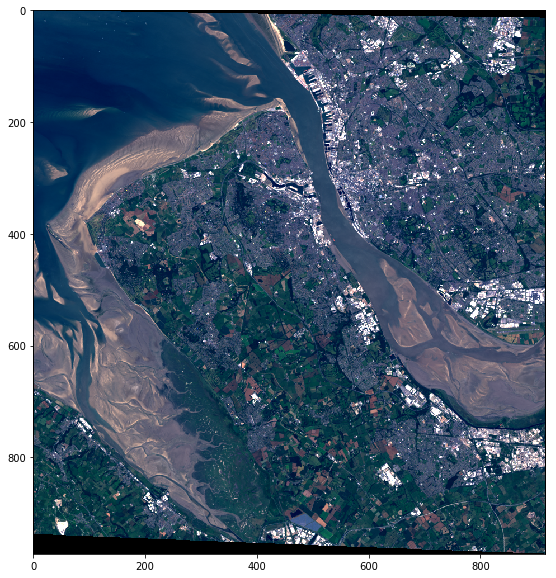

In [224]:
# Use the defined function to display the image
color_image_show(img_exp)

In [218]:
# Save image to file
io.imsave('RGB.TIF', img_exp)